In [1]:
import glob
import jsonlines
from pathlib import Path
import natsort
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
annotations_dir = "/media/data/warp_data/marine_detection/imerit/whoi-rsi-fish-detection-datasets-22122023"
manifest_path = "/media/data/warp_data/marine_detection/imerit/whoi-rsi-fish-detection-datasets-22122023/28102023_manifest.json"

In [3]:
annotation_files = glob.glob(f"{annotations_dir}/annotations/consolidated-annotation/output/*/*.json")
annotation_files = natsort.natsorted(annotation_files)

In [4]:
def manifest2ordered_videos(manifest_path, replace_root=""):
    # Annotation folders are ordered by an id number with starting index 0
    ordered_video_dirs = []
    with jsonlines.open(manifest_path) as f:
        for video_num, video_json in enumerate(f):
            video_path = Path(video_json['source-ref'].replace(replace_root, ""))
            ordered_video_dirs.append(video_path.parent)
    return ordered_video_dirs
    
ordered_video_dirs = manifest2ordered_videos(manifest_path, replace_root="s3://whoi-rsi-fish-detection/datasets/imerit_26102023_clips/")

In [8]:
num_annotated_frames = 0
all_fish_areas = []
fish_in_each_video = []
fish_in_each_frame = []
num_unique_fish_in_each_video = []
num_frames_each_unique_fish_appears_in = []
vid_nums = []

for a_f in annotation_files:
    with jsonlines.open(a_f) as reader:
        vid_num = Path(a_f).parent.name
        vid_nums.append(vid_num)
        
        for check, video_seq in enumerate(reader):
            assert check == 0 # each json just has one long line

            num_frames_with_annotations = len(video_seq['tracking-annotations'])
            num_annotated_frames += num_frames_with_annotations
            
            unique_fish_names = []
            unique_fish_ids = []
            unique_fish_counts = {}
            
            num_fish_per_video = 0
            
            for ann_frame_num, per_frame in enumerate(video_seq['tracking-annotations']):
                # keys: (['annotations', 'frame-no', 'frame', 'frame-attributes'])
                annotations = per_frame['annotations']
                num_fish_per_frame = len(annotations)
                num_fish_per_video += num_fish_per_frame
                
                for fish in annotations:
                    #keys: (['height', 'width', 'top', 'left', 'class-id', 'label-category-attributes', 'object-id', 'object-name'])
                    
                    # unique fish
                    obj_id = fish['object-id']
                    obj_name = fish['object-name']
                    if obj_id not in unique_fish_ids:
                        unique_fish_ids.append(obj_id)
                    if obj_name not in unique_fish_names:
                        unique_fish_names.append(obj_name)
                        
                    # how many frames did this unique fish appear in
                    if obj_id in unique_fish_counts:
                        unique_fish_counts[obj_id] += 1
                    else:
                        unique_fish_counts[obj_id] = 0
                        
                    # area
                    area = fish['height'] * fish['width']
                    all_fish_areas.append(area)
                
                fish_in_each_frame.append(num_fish_per_frame)

            for k,v in unique_fish_counts.items():
                num_frames_each_unique_fish_appears_in.append(v)
            
            fish_in_each_video.append(num_fish_per_video)
            num_unique_fish_in_each_video.append(len(unique_fish_names))
            assert len(unique_fish_names) == len(unique_fish_ids)
                
print(f"Number of videos: {len(annotation_files)}")
print(f"Number of annotated frames: {num_annotated_frames} out of {len(annotation_files) * 90}")
print(f"Total number of annotated boxes: {len(all_fish_areas)}")

print(f"Average area of each annotated box: {np.mean(all_fish_areas)} +/- {np.std(all_fish_areas)} pixels^2")
print(f"Biggest fish: {max(all_fish_areas)} pixels^2")

print(f"Number of unique fish: {np.sum(num_unique_fish_in_each_video)}")
print(f"Average number of unique fish per video: {np.mean(num_unique_fish_in_each_video)} +/- {np.std(num_unique_fish_in_each_video)}")
print(f"Average number of frames per unique fish: {np.mean(num_frames_each_unique_fish_appears_in)} +/- {np.std(num_frames_each_unique_fish_appears_in)}")
print(f"Average number of fish per frame: {np.mean(fish_in_each_frame)} +/- {np.std(fish_in_each_frame)}")

{'annotations': [{'height': 9, 'width': 20, 'top': 306, 'left': 1472, 'class-id': '0', 'label-category-attributes': {}, 'object-id': '741ae780-786e-11ee-bebf-376ffd340979', 'object-name': 'fish:1'}, {'height': 12, 'width': 22, 'top': 157, 'left': 1521, 'class-id': '0', 'label-category-attributes': {}, 'object-id': '7da27ac0-786e-11ee-bebf-376ffd340979', 'object-name': 'fish:2'}, {'height': 15, 'width': 18, 'top': 175, 'left': 1596, 'class-id': '0', 'label-category-attributes': {}, 'object-id': '7f36af50-786e-11ee-bebf-376ffd340979', 'object-name': 'fish:3'}, {'height': 19, 'width': 25, 'top': 131, 'left': 1845, 'class-id': '0', 'label-category-attributes': {}, 'object-id': '81412550-786e-11ee-bebf-376ffd340979', 'object-name': 'fish:4'}, {'height': 14, 'width': 19, 'top': 237, 'left': 1699, 'class-id': '0', 'label-category-attributes': {}, 'object-id': '85d63dd0-786e-11ee-bebf-376ffd340979', 'object-name': 'fish:5'}, {'height': 14, 'width': 22, 'top': 76, 'left': 1820, 'class-id': '0',

IndexError: list index out of range

/media/data/anaconda3_envs/aws_labelbox/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


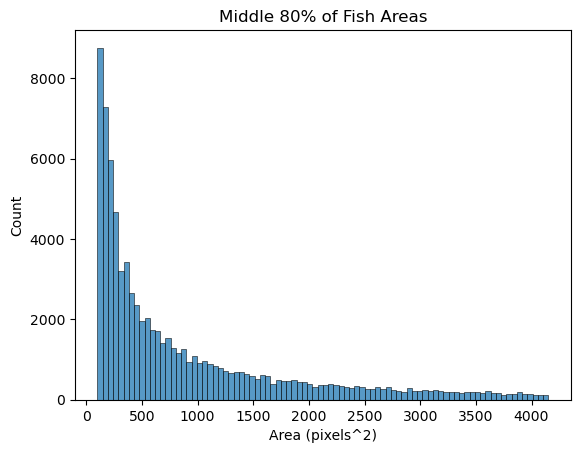

In [6]:
all_fish_areas.sort()
lower = int(len(all_fish_areas) * 0.1)
upper = int(len(all_fish_areas) * 0.9)

plt.figure()
sns.histplot(all_fish_areas[lower:upper])
plt.title("Middle 80% of Fish Areas")
plt.xlabel("Area (pixels^2)")
plt.show()

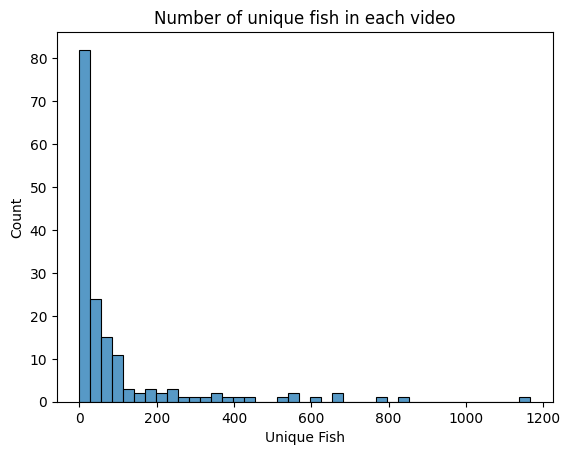

In [111]:

plt.figure()
sns.histplot(num_unique_fish_in_each_video)
plt.title("Number of unique fish in each video")
plt.xlabel("Unique Fish")
plt.show()


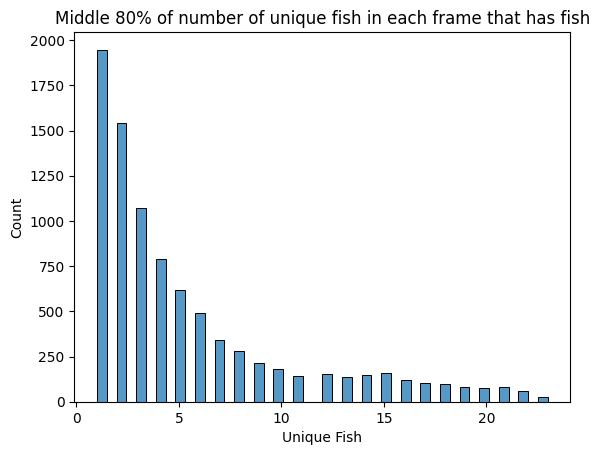

In [132]:
fish_in_each_frame.sort()
lower = int(len(fish_in_each_frame) * 0.1)
upper = int(len(fish_in_each_frame) * 0.9)



plt.figure()
sns.histplot(fish_in_each_frame[lower:upper])
plt.title("Middle 80% of number of unique fish in each frame that has fish")
plt.xlabel("Unique Fish")
plt.show()
